In [1]:
import pandas as pd, matplotlib.pyplot as plt, numpy as np
import statsmodels.api as sm
lm = sm.WLS
from csdid.att_gt import ATTgt
df = pd.read_csv('../data/r_cohort.csv')
r_inf = pd.read_csv('../data/r_inf.csv')
df.head()

,customer_id,ttm_gms,wplus,prime,time_period,treatment,ln_gms,first.treat,cohort,customer_id_num,post,treat
0,Pa0jpC-Dv2fTYelpx8erNpaYw,1643.55,wp_never,npa,1,0,7.404614,0,0,8681,0,0
1,Pa0E0tPLH1dQ6qalsrWJ8lpxA,1405.19,wp_never,npa,1,0,7.247928,0,0,5683,0,0
2,Pa0mRRL9DhSRqOah4yOYKMpaw,46839.30,wp_never,npa,1,0,10.754478,0,0,10307,0,0
3,Pa0_dznuzjsRv6GDlIw1pLTsQ,631.88,wp_never,npa,1,0,6.448700,0,0,367,0,0
4,Pa05HYdf_XvTb-aN6Mx2ws4iA,134.95,wp_never,npa,1,0,4.904904,0,0,2128,0,0


In [2]:
def reg_did_panel(y1, y0, D, covariates, i_weights=None):
    D = np.asarray(D).flatten()
    n = len(D)
    deltaY = np.asarray(y1 - y0).flatten()
    int_cov = np.ones((n, 1))
    
    if covariates is not None:
        covariates = np.asarray(covariates)
        if np.all(covariates[:, 0] == 1):
            int_cov = covariates
        else:
            int_cov = np.column_stack((np.ones(n), covariates))
    
    if i_weights is None:
        i_weights = np.ones(n)
    elif np.min(i_weights) < 0:
        raise ValueError("i_weights must be non-negative")
    
    i_weights = i_weights / np.mean(i_weights)
    
    mask = D == 0
    X = int_cov[mask]
    y = deltaY[mask]
    w = i_weights[mask]
    
    # reg_coeff = np.linalg.lstsq(X * w[:, np.newaxis], y * w, rcond=None)[0]
    reg_coeff = lm(y, X, weights=w).fit().params
    print(reg_coeff)
    
    if np.any(np.isnan(reg_coeff)):
        raise ValueError("Outcome regression model coefficients have NA components. \n Multicollinearity (or lack of variation) of covariates is probably the reason for it.")
    
    out_delta = np.dot(int_cov, reg_coeff)
    w_treat = i_weights * D
    w_cont = i_weights * (1 - D)
    reg_att_treat = w_treat * deltaY
    reg_att_cont = w_cont * out_delta
    eta_treat = np.mean(reg_att_treat) / np.mean(w_treat)
    eta_cont = np.mean(reg_att_cont) / np.mean(w_cont)
    reg_att = eta_treat - eta_cont
    
    weights_ols = i_weights * (1 - D)
    wols_x = weights_ols[:, np.newaxis] * int_cov
    wols_eX = weights_ols[:, np.newaxis] * (deltaY - out_delta)[:, np.newaxis] * int_cov
    XpX_inv = np.linalg.inv(np.dot(wols_x.T, int_cov) / n)
    asy_lin_rep_ols = np.dot(wols_eX, XpX_inv)
    
    inf_treat = (reg_att_treat - w_treat * eta_treat) / np.mean(w_treat)
    # print(np.sum(w_treat * eta_treat))
    
    inf_cont_1 = (reg_att_cont - w_cont * eta_cont)
    M1 = np.mean(w_cont[:, np.newaxis] * int_cov, axis=0)
    inf_cont_2 = np.dot(asy_lin_rep_ols, M1)
    inf_control = (inf_cont_1 + inf_cont_2) / np.mean(w_cont)
    
    reg_att_inf_func = (inf_treat - inf_control)
    se_reg_att = np.std(reg_att_inf_func) / np.sqrt(n)
    
    return reg_att, reg_att_inf_func


In [3]:
out = ATTgt(yname="ln_gms",gname="first.treat", idname="customer_id_num",
     tname="time_period", data=df).fit(est_method=reg_did_panel)
# Display the results
out.summ_attgt().summary2

[-0.07668271]


,Group,Time,"ATT(g, t)",Post,Std. Error,[95% Pointwise,Conf. Band],
0,2,2,-0.0746,0,0.0316,-0.134,-0.0153,*


In [4]:
inf_py = out.inf_f[0]
# len(r_inf), len(inf_py)
r_inf['py'] = inf_py
r_inf['diff_2'] = r_inf['inf1'] / r_inf['py']

In [5]:
r_inf.shape

(17497, 3)

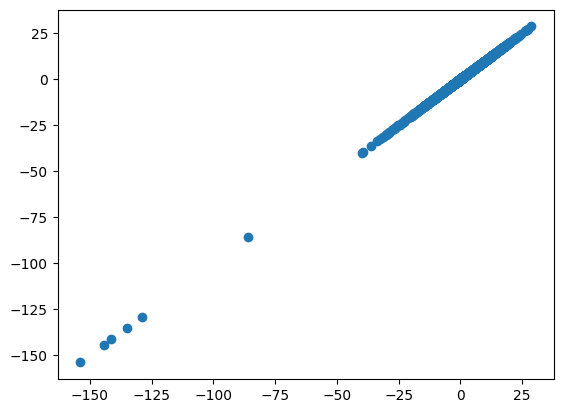

In [6]:
r = r_inf['inf1'].values
py = out.inf_f[0]
plt.scatter(r, py)

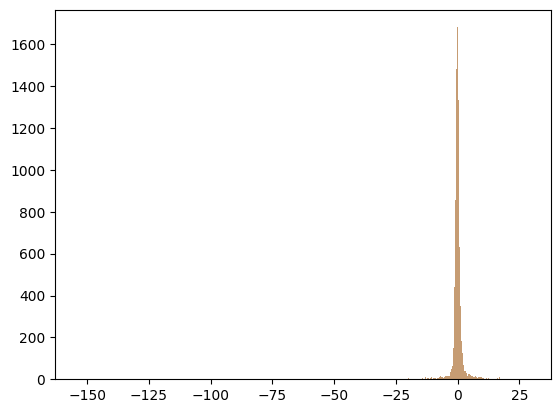

In [7]:
plt.hist(r, label="r", alpha = 0.5, bins = 1000)
plt.hist(py, label="r", alpha = 0.5, bins = 1000)
plt.show()

In [10]:
r_inf['diff_2'].describe()

count    1.749700e+04
mean     1.000000e+00
std      3.329477e-14
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+00
Name: diff_2, dtype: float64